In [44]:
# imports
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
import copy
import os, sys, pathlib
import yaml
import json
import requests

from deq2ff.plotting.style import (
    set_seaborn_style,
    PALETTE,
    entity,
    projectmd,
    projectoc,
    plotfolder,
    human_labels,
    set_style_after,
    myrc,
)
from deq2ff.plotting.dashboard import get_runs_from_wandb, filter_best_runs, mark_sota, add_best_run, preprocess_df, print_table_acc_time

nans = ["NaN", pd.NA, None, float("inf"), np.nan]



In [45]:
# set sns color palette to one blue, three shades of orange
# sns.set_palette(sns.color_palette(["#1f77b4", "#ff7f0e", "#ffbb78", "#2ca02c"]))
# sns.set_palette(sns.color_palette(["#1f77b4", "#E97451", "#E3963E", "#FFC000"]))
# sns.set_palette(sns.color_palette(["#1f77b4", "#E97451", "#FFC000", "#EC5800"])) 
# oranges: #fdbe85 #fd8d3c #e6550d #a63603
# okka #fe9929
# blues: # #8c96c6 #8856a7
# teals: #b2e2e2 #66c2a4 #2ca25f
cdict = {
    # blues
    "DEQ1": "#fdcc8a",
    "DEQ2": "#fe9929",
    # oranges
    "E1": "#b2e2e2",
    "E4": "#66c2a4",
    "E8": "#2b8cbe", # 2ca25f 2b8cbe
}
cdict = {
    # https://www.colorhexa.com/ffb347
    # https://www.colorhexa.com/ffb347
    "DEQ1": "#F8A874", # F8A874 #FBCEB1
    "DEQ2": "#F58238",
    # https://www.picmonkey.com/colors/blue/pastel-blue 
    # https://www.picmonkey.com/colors/gray/slate
    "E1": "#AEC6CF",
    "E4": "#5E8D9F",
    "E8": "#476A77", # 2ca25f 2b8cbe
}

# set_seaborn_style()

# MD17, MD22

In [46]:
# Config
project = projectmd

if project == projectmd:
    error_metric = "summary.test_f_mae"
    energy_metric = "summary.test_e_mae"
elif project == projectoc:
    # summary.train/forces_mae, val, 
    error_metric = "summary.val/forces_mae"
    energy_metric = "summary.val/energy_mae"

In [47]:
df = get_runs_from_wandb(
    project=project, download_data=True,
    filters = {
        # https://www.mongodb.com/docs/manual/reference/operator/query-comparison/
        "$or": [{"state": "finished"}, {"state": "crashed"}],
        "tags": {"$nin": ["eval", "inf"]}
    }
)
df = preprocess_df(df=df, project=project, error_metric=error_metric)

Found 392 runs:
Saved dataframe.
before filter: 392
after filter: 387


In [48]:
# print([k for k in df.keys() if k.startswith("summary.test")])
# print([k for k in df.keys() if k.startswith("summary.val")])
# print([k for k in df.keys() if k.startswith("config.deq_kwargs")])
# df[["run_name", "config.target", error_metric]]

In [49]:
if project == projectmd:
    df_best_runs = filter_best_runs(
        df=df, error_metric=error_metric,
        # "config.norm_by_natoms" can be False or NaN, but not True
        # config.dname can be md17 or md22 but not ccsd
        anti_criteria={
            "config.decay_rate": 1,
            "config.dname": "ccsd",
            "config.norm_by_natoms": True,
            "config.model.forces_via_grad": True,
        }
    )

elif project == projectoc:
    df_best_runs = filter_best_runs(
        df=df, error_metric=error_metric,
        criteria={
            "config.model.attn_alpha_channels": 64, # reg
        },
        anti_criteria={
            "config.decay_rate": 1, # constlr
        }
    )

In [50]:
if project == projectoc:
    targets = ["200k e3", "2M e1"]
    df_best_runs = df_best_runs[df_best_runs["config.target"].isin(targets)]

In [51]:
df_best_runs = mark_sota(df_best_runs, comparison="pairwise", error_metric=error_metric)

# defragment
df_best_runs = df_best_runs.copy()

Models: ['DEQ1' 'DEQ2' 'E1' 'E4' 'E8']


/ssd/gen/equilibrium-forcefields/src/deq2ff/plotting/dashboard.py:334: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _df["sota"] = False


In [52]:
# df_best_runs[df_best_runs["sota"] == True][["run_name", "config.target", error_metric, "sota"]]

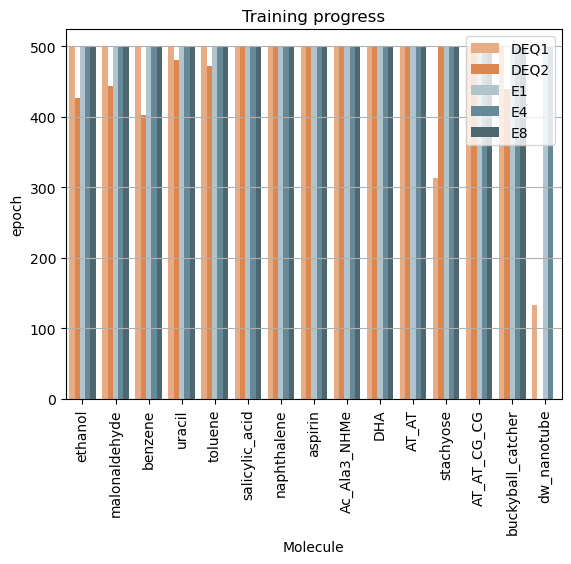

In [53]:
# plot how far training has progressed (steps / epochs)
if project == projectmd:
    y = "summary.epoch"
elif project == projectoc:
    y = "summary.train/step"
x = "config.target"
hue = "Model"
data = df_best_runs.copy()

# plot
fig, ax = plt.subplots()
# pallete: dictionary mapping hue levels to matplotlib colors
sns.barplot(
    x=x, y=y, hue=hue, data=data, ax=ax, palette=cdict, 
    # gap=0.1
)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))
plt.title("Training progress")

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
plt.show()

In [54]:
# runs I need to reinitialize
if project == projectmd:
    prefix = "launchrun"
    
    # runs with DEQ2
    df_deq2 = df_best_runs[df_best_runs["Model"] == "DEQ2"]
    # print commands used to launch these runs
    for i, row in df_deq2.iterrows():
        # print(f"epoch {row['summary.epoch']} {rname['config.epochs']}")
        if row['summary.epoch'] >= row['config.epochs'] - 1:
            continue
        overrides = row['config.override_dirname'].split(',')
        overrides = [o for o in overrides if "wandb_tags" not in o]
        overrides = " ".join([f"{o}" for o in overrides])
        print(f"{prefix} {overrides}")

launchrun +cfg=ap +use=deq model.num_layers=2 target=ethanol
launchrun +cfg=bp +use=deq model.num_layers=2 target=malonaldehyde
launchrun +cfg=ap +use=deq model.num_layers=2 target=benzene
launchrun +cfg=bp +use=deq model.num_layers=2 target=uracil
launchrun +cfg=bp +use=deq model.num_layers=2 target=toluene
launchrun +cfg=apt +use=deq dname=md22 model.num_layers=2 target=buckyball_catcher


In [55]:
# speedtest: give me the commands I need to run
if project == projectmd:
    prefix = "launchrun"
    tag = "['speedmd_v1']"
elif project == projectoc:
    prefix = "launchoc"
    tag = "['speedoc_v1']"
    
# df[["config.override_dirname"]]
# for i, row in df_best_runs.iterrows():
#     print(f"{prefix} {row['config.override_dirname'].replace(',', ' ')} +inf=bs1 wandb_tags={tag}")

In [56]:
df_best_runs[["Model", "config.target", error_metric, "sota"]]

,Model,config.target,summary.test_f_mae,sota
116,DEQ1,ethanol,0.223964,False
253,DEQ2,ethanol,0.206842,True
6,E1,ethanol,0.292738,False
7,E4,ethanol,0.222168,True
8,E8,ethanol,0.217541,False
...,...,...,...,...
41,E4,buckyball_catcher,0.093443,True
42,E8,buckyball_catcher,0.079218,True
101,DEQ1,dw_nanotube,0.489789,False
43,E1,dw_nanotube,0.604777,False


In [57]:
# TODO: add speed to table
time_metric = "summary.test_time_fpreuse"

# dfspeed = get_runs_from_wandb(
#     project=project, download_data=True, 
#     filters = {
#         "tags": "speedmd_v1",
#         # "$and": [{"tags": "md17"}, {"tags": "eval"}],
#         # "state": "finished",
#         # "$or": [{"tags": "md17"}, {"tags": "main2"}, {"tags": "inference"}],
#         "state": "finished",
#         # "$or": [{"state": "finished"}, {"state": "crashed"}],
#     }, 
#     fname="speedmdv1"
# )

# dfspeed = preprocess_df(df=dfspeed, project=project, error_metric=time_metric)

# # TODO: add sotatime column
# dfspeed = mark_sota(dfspeed, comparison="pairwise", error_metric=time_metric)

In [58]:
# print table of results for MD

print_table_acc_time(
    df = df_best_runs,
    dnames=["md17"], 
    ex_targets=["dw_nanotube"], 
    models=["E1", "E4", "E8", "DEQ1", "DEQ2"],
    error_metric=error_metric,
    time_metric=time_metric,
)



egin{tabular}{l}cccccccccccccccc}
	oprule[1.2pt]
 & \multicolumn2{c}{Ethanol} & \multicolumn2{c}{Malonaldehyde} & \multicolumn2{c}{Benzene} & \multicolumn2{c}{Uracil} & \multicolumn2{c}{Toluene} & \multicolumn2{c}{Salicylic acid} & \multicolumn2{c}{Naphthalene} & \multicolumn2{c}{Aspirin} \
\cmidrule[0.6pt]{2-17}
\midrule[1.2pt]
\equiformer{} (1 layer) & 0.29 & ... & 0.42 & ... & 0.21 & ... & 0.38 & ... & 0.17 & ... & 0.42 & ... & 0.15 & ... & 0.54 & ... \
\equiformer{} (4 layers) & \textbf{0.22} & ... & 0.32 & ... & \textbf{0.19} & ... & \textbf{0.30} & ... & \textbf{0.13} & ... & 0.34 & ... & \textbf{0.12} & ... & 0.40 & ... \
\equiformer{} (8 layers) & 0.22 & ... & 0.31 & ... & \textbf{0.18} & ... & 0.31 & ... & \textbf{0.13} & ... & 0.34 & ... & 0.12 & ... & 0.42 & ... \
\midrule[0.6pt]
DEQ (1 layer) & 0.22 & ... & \textbf{0.31} & ... & 0.21 & ... & 0.34 & ... & 0.15 & ... & \textbf{0.31} & ... & 0.15 & ... & \textbf{0.37} & ... \
DEQ (2 layers) & \textbf{0.21} & ... & \textbf{0.3

['\x08egin{tabular}{l}cccccccccccccccc}',
 '\toprule[1.2pt]',
 ' & \\multicolumn2{c}{Ethanol} & \\multicolumn2{c}{Malonaldehyde} & \\multicolumn2{c}{Benzene} & \\multicolumn2{c}{Uracil} & \\multicolumn2{c}{Toluene} & \\multicolumn2{c}{Salicylic acid} & \\multicolumn2{c}{Naphthalene} & \\multicolumn2{c}{Aspirin} \\',
 '\\cmidrule[0.6pt]{2-17}',
 '\\midrule[1.2pt]',
 '\\equiformer{} (1 layer) & 0.29 & ... & 0.42 & ... & 0.21 & ... & 0.38 & ... & 0.17 & ... & 0.42 & ... & 0.15 & ... & 0.54 & ... \\',
 '\\equiformer{} (4 layers) & \\textbf{0.22} & ... & 0.32 & ... & \\textbf{0.19} & ... & \\textbf{0.30} & ... & \\textbf{0.13} & ... & 0.34 & ... & \\textbf{0.12} & ... & 0.40 & ... \\',
 '\\equiformer{} (8 layers) & 0.22 & ... & 0.31 & ... & \\textbf{0.18} & ... & 0.31 & ... & \\textbf{0.13} & ... & 0.34 & ... & 0.12 & ... & 0.42 & ... \\',
 '\\midrule[0.6pt]',
 'DEQ (1 layer) & 0.22 & ... & \\textbf{0.31} & ... & 0.21 & ... & 0.34 & ... & 0.15 & ... & \\textbf{0.31} & ... & 0.15 & ... & \\t

In [59]:
# plot acc vs speed Pareto front
if project == projectmd: 
    tag = "paretomd_v1"
    fname = "mdv1"

    dfpareto = get_runs_from_wandb(
        project=project, download_data=True, 
        filters = {
            "tags": tag,
            # "$and": [{"tags": "md17"}, {"tags": "eval"}],
            # "state": "finished",
            # "$or": [{"tags": "md17"}, {"tags": "main2"}, {"tags": "inference"}],
            "state": "finished",
            # "$or": [{"state": "finished"}, {"state": "crashed"}],
        }, 
        fname="pareto" + fname
    )
    """
    launchrun +use=deq +cfg=ap deq_kwargs.b_stop_mode=rel deq_kwargs.f_tol=1e-4 deq_kwargs_test.f_tol=
    launchrun +use=deq +cfg=ap deq_kwargs.b_stop_mode=rel deq_kwargs.f_tol=1e-6 deq_kwargs_test.f_tol=
    """
    
    if len(dfpareto) > 0:
        dfpareto = preprocess_df(df=dfpareto, project=project, error_metric=error_metric)
        
        y = "summary.test_f_mae" # test_fpreuse_f_mae
        x = "summary.test_fpreuse_time"
        hue = "Class"
        data = dfpareto.copy()

        # plot
        fig, ax = plt.subplots()
        sns.scatterplot(
            x=x, y=y, hue=hue, data=data, ax=ax, 
            # palette=cdict
        )
        plt.legend()
        plt.xlabel(human_labels(x))
        plt.ylabel(human_labels(y))

        # vertical xtick labels
        # plt.xticks(rotation=90)

        # horizontal grid
        plt.grid(axis="y")

        # make a separate plot for each target

        # save
        # plt.savefig(f"{plotfolder}/n_steps.png")
        plt.show()

Found 0 runs:
Saved dataframe.


In [60]:
# df_best_runs[["run_name", "config.target", "Model", "summary.train/step", "config.optim.max_epochs", "summary.train/epoch"]]
df_best_runs[df_best_runs["config.target"] == "aspirin"][["run_name", "config.target", "Model", "summary.train/step", "config.optim.max_epochs", "summary.train/epoch"]]

,run_name,config.target,Model,summary.train/step,config.optim.max_epochs,summary.train/epoch
69,pDEQs bp seed-3 aspirin,aspirin,DEQ1,NaN,NaN,NaN
94,pDEQs bp numlayers-2 aspirin,aspirin,DEQ2,NaN,NaN,NaN
57,pEs dd numlayers-1 seed-3 aspirin,aspirin,E1,NaN,NaN,NaN
54,pEs dd seed-3 aspirin,aspirin,E4,NaN,NaN,NaN
58,pEs dd numlayers-8 seed-2 aspirin,aspirin,E8,NaN,NaN,NaN


In [61]:
# ignore target==dw_nanotube
df_best_runs = df_best_runs[df_best_runs["config.target"] != "dw_nanotube"]

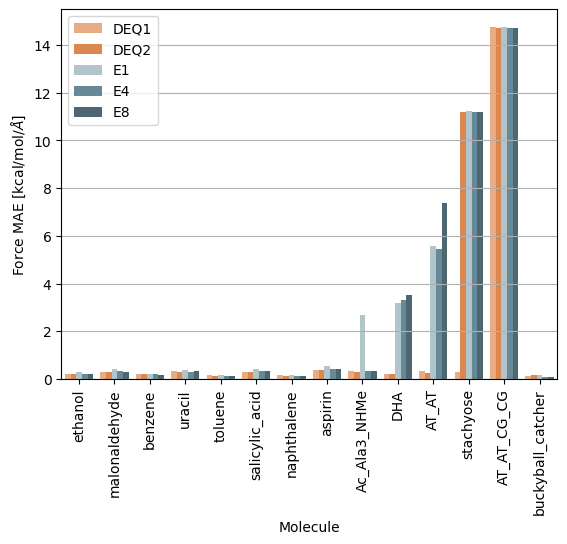

In [62]:
# plot accuracy
# grouped barchart, with target as group, and model as hue
y = error_metric
x = "config.target"
hue = "Model"
data = df_best_runs.copy()

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax, palette=cdict)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/n_steps.png")
plt.show()

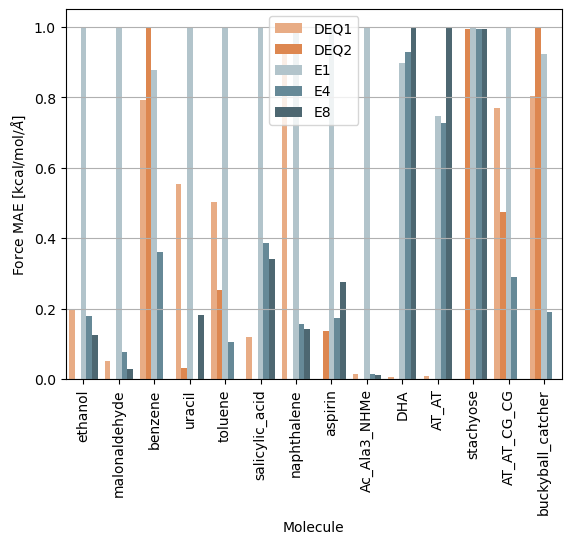

In [63]:
# plot accuracy, normalized for each target

def plot_norm_acc(_df, norm_scheme="minmax"): # norm_scheme = "zscoree4" # "mean", "minmax", "zscore", "zscoree4"

    # grouped barchart, with target as group, and model as hue
    y = error_metric
    x = "config.target"
    hue = "Model"
    data = _df.copy()

    # normalize
    ylabel = error_metric
    if norm_scheme == "minmax":
        data[error_metric] = data.groupby("config.target")[error_metric].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
        ylabel = human_labels(y) + " (minmax)"
    elif norm_scheme == "minmax2":
        # instead of [0, 1], normalize to [-1, 1] 
        data[error_metric] = data.groupby("config.target")[error_metric].transform(lambda x: 2 * (x - x.min()) / (x.max() - x.min()) - 1)
        ylabel = human_labels(y) + " (normed to [-1, 1])"

    elif norm_scheme == "minmax3":
        # normalize to [0.1, 1]
        data[error_metric] = data.groupby("config.target")[error_metric].transform(lambda x: 0.9 * (x - x.min()) / (x.max() - x.min()) + 0.1)
        ylabel = human_labels(y) + " (normed to [0.1, 1])"

    elif norm_scheme == "mean":
        data[error_metric] = data.groupby("config.target")[error_metric].transform(lambda x: x / x.mean())
        ylabel = human_labels(y) + " (zero mean)"
    elif norm_scheme == "zscore":
        data[error_metric] = data.groupby("config.target")[error_metric].transform(lambda x: (x - x.mean()) / x.std())
        ylabel = human_labels(y) + " (zscore)"
    elif norm_scheme == "zscoree4":
        # instead of substracing the mean, substract E4
        for t in data["config.target"].unique():
            _mean = data[(data["config.target"] == t) & (data["Model"] == "E4")][error_metric].mean()
            _std = data[data["config.target"] == t][error_metric].std()
            data.loc[data["config.target"] == t, error_metric] = (data[data["config.target"] == t][error_metric] - _mean) / _std
        ylabel = human_labels(y) + " (zscore around mean=E4)"

    elif norm_scheme == "zscoree4":
        # instead of substracing the mean, substract E4
        for t in data["config.target"].unique():
            _mean = data[(data["config.target"] == t) & (data["Model"] == "E8")][error_metric].mean()
            _std = data[data["config.target"] == t][error_metric].std()
            data.loc[data["config.target"] == t, error_metric] = (data[data["config.target"] == t][error_metric] - _mean) / _std
        ylabel = human_labels(y) + " (zscore around mean=E8)"
    else:
        raise NotImplementedError



    # plot
    fig, ax = plt.subplots()
    sns.barplot(
        x=x, y=y, hue=hue, data=data, ax=ax, palette=cdict
    )
    plt.legend()
    plt.xlabel(human_labels(x))
    plt.ylabel(human_labels(y))

    # where "sota" is True, mark the run with a green star
    # for target in data["config.target"].unique():
    #     _df = data[data["config.target"] == target]
    #     _df = _df[_df["sota"] == True]
    #     for index in _df.index:
    #         ax.plot(index, _df.loc[index, y], "o", color="green", markersize=10)

    # vertical xtick labels
    plt.xticks(rotation=90)

    # horizontal grid
    plt.grid(axis="y")

    # make a separate plot for each target

    # save
    # plt.savefig(f"{plotfolder}/n_steps.png")
    plt.show()

plot_norm_acc(df_best_runs, norm_scheme="minmax")

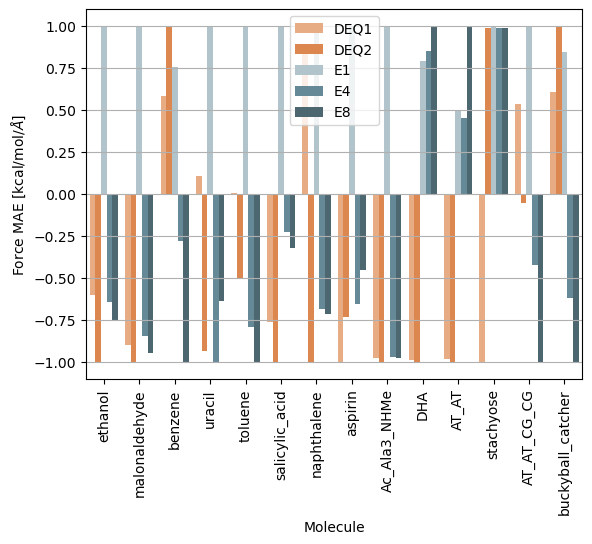

In [64]:
plot_norm_acc(df_best_runs, norm_scheme="minmax2")


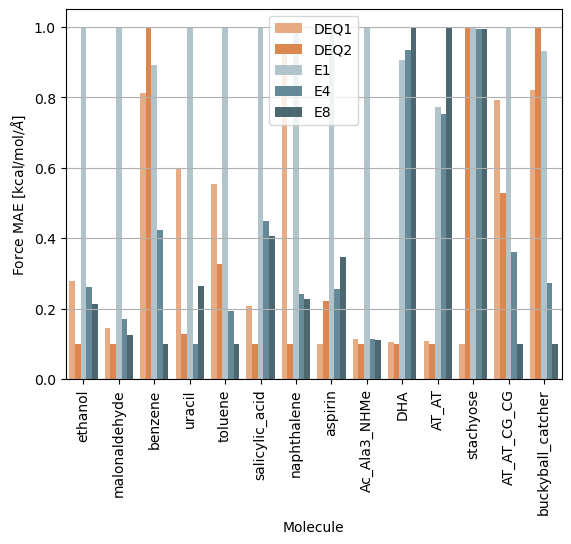

In [65]:
plot_norm_acc(df_best_runs, norm_scheme="minmax3")


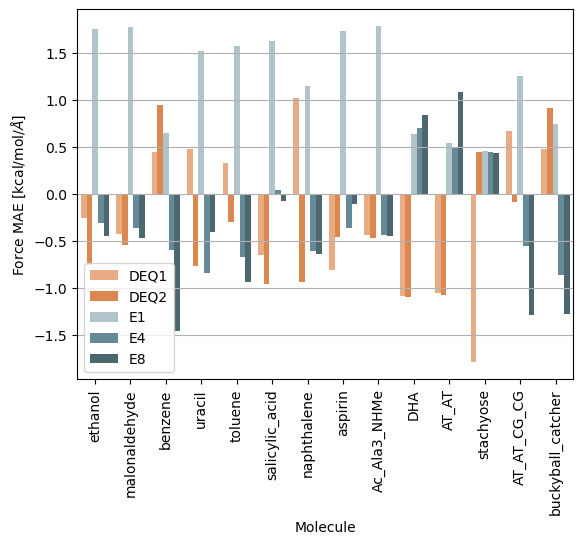

In [66]:
plot_norm_acc(df_best_runs, norm_scheme="zscore")

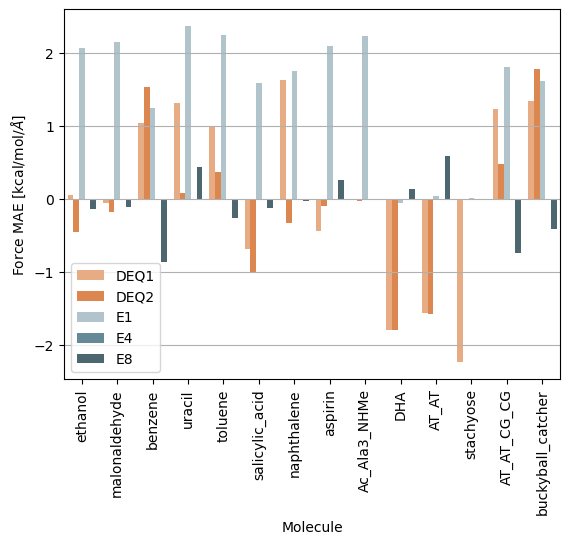

In [67]:
plot_norm_acc(df_best_runs, norm_scheme="zscoree4")

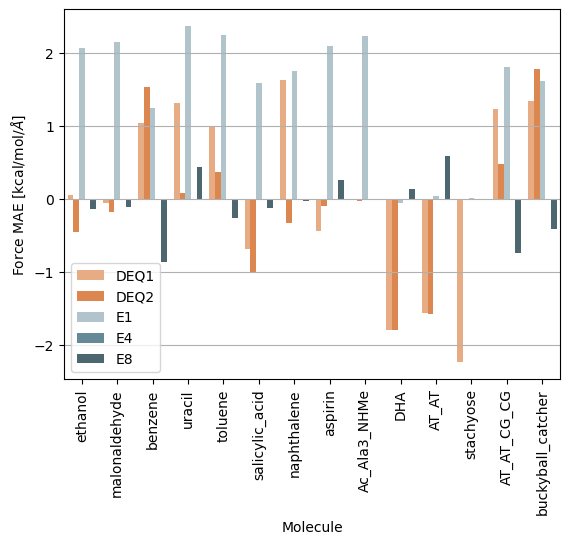

In [68]:
plot_norm_acc(df_best_runs, norm_scheme="zscoree4")


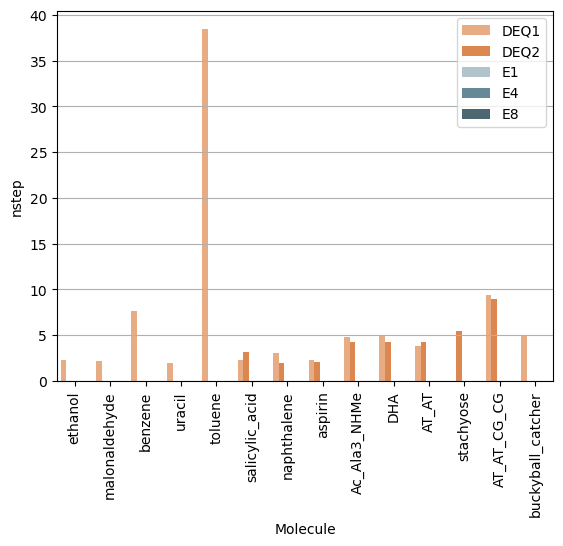

In [69]:
# plot n_step
# grouped barchart, with target as group, and model as hue

y = "nstep"
x = "config.target"
hue = "Model"
data = df_best_runs.copy()

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax, palette=cdict)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/n_steps.png")
plt.show()

# print names of plotted runs
# data["run_name"]

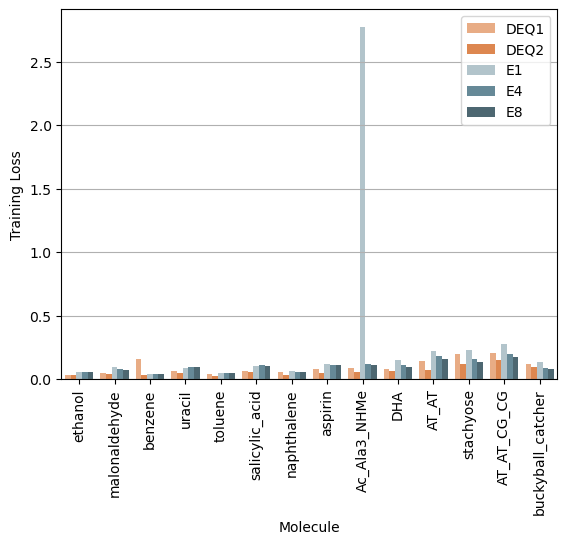

In [70]:
# plot train_loss_f

# grouped barchart, with target as group, and model as hue
if project == projectmd:
    y = "summary.train_loss_f"
elif project == projectoc:
    y = "summary.train/forces_mae"
x = "config.target"
hue = "Model"

data = df_best_runs.copy()
# DEQ is in the model name
# data = data["DEQ" in data["Model"]]
# data = data[df["Model"].str.startswith('DEQ')]

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax, palette=cdict)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/train_loss_f.png")
plt.show()

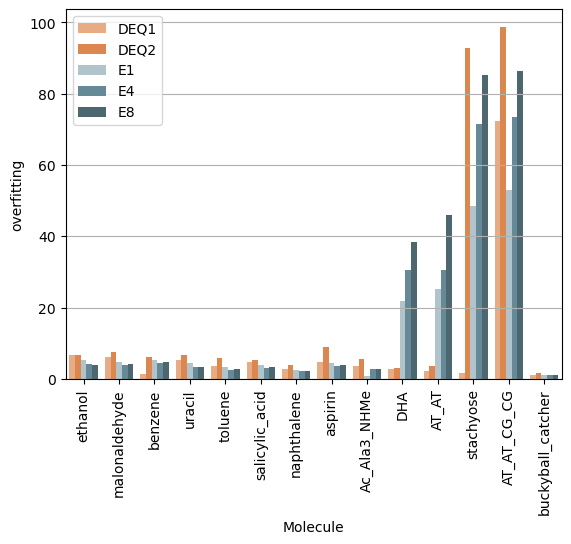

In [71]:
# overfitting = test_loss / train_loss
if project == projectmd:
    df_best_runs["overfitting"] = df_best_runs["summary.test_f_mae"] / df_best_runs["summary.train_loss_f"]
elif project == projectoc:
    df_best_runs["overfitting"] = df_best_runs["summary.val/forces_mae"] / df_best_runs["summary.train/forces_mae"]

y = "overfitting"
x = "config.target"
hue = "Model"

data = df_best_runs.copy()
# DEQ is in the model name
# data = data["DEQ" in data["Model"]]
# data = data[df["Model"].str.startswith('DEQ')]

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax, palette=cdict)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/train_loss_f.png")
plt.show()

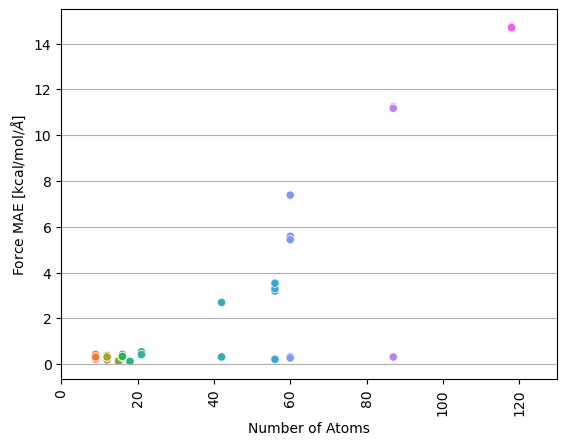

In [72]:
# plot test loss per molecule

if project == projectmd:
    fig, ax = plt.subplots()
    # sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
    # scatterplot 
    x = "num_atoms"
    # y = "summary.test_loss_f" # TODO: no longer logged?
    y = "summary.test_f_mae" # TODO: no longer logged?
    hue = "config.target"
    sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
    plt.legend()
    plt.xlabel(human_labels(x))
    plt.ylabel(human_labels(y))

    # vertical xtick labels
    plt.xticks(rotation=90)

    ax.set_xlim(0, 130)
    
    ax.get_legend().remove()

    # horizontal grid
    plt.grid(axis="y")

    # make a separate plot for each target

    # save
    # plt.savefig(f"{plotfolder}/train_loss_f.png")
    plt.show()

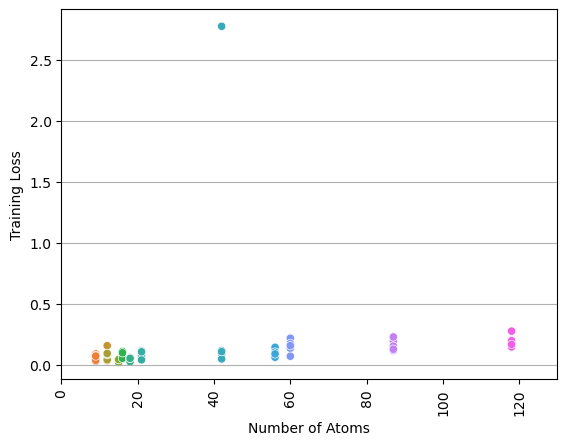

In [73]:
# plot train loss per molecule

if project == projectmd:
    fig, ax = plt.subplots()
    # sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
    # scatterplot 
    x = "num_atoms"
    y = "summary.train_loss_f"
    hue = "config.target"
    sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
    plt.legend()
    plt.xlabel(human_labels(x))
    plt.ylabel(human_labels(y))

    # vertical xtick labels
    plt.xticks(rotation=90)

    # legend off
    ax.set_xlim(0, 130)
    
    ax.get_legend().remove()

    # horizontal grid
    plt.grid(axis="y")

    # make a separate plot for each target

    # save
    # plt.savefig(f"{plotfolder}/train_loss_f.png")
    plt.show()

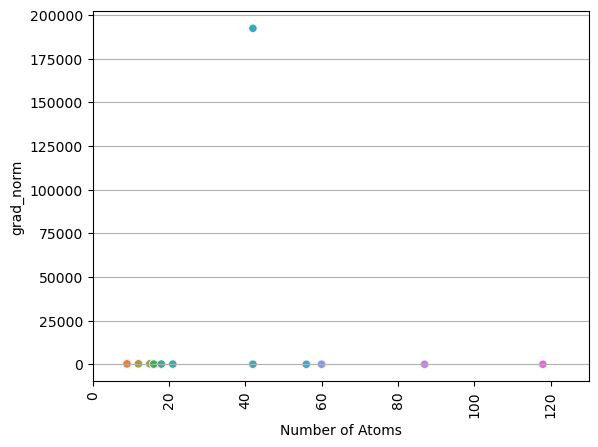

In [74]:
# plot gradient norm per molecule

fig, ax = plt.subplots()
# sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
# scatterplot 
x = "num_atoms"
y = "summary.grad_norm"
hue = "config.target"
sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

ax.set_xlim(0, 130)
    
ax.get_legend().remove()

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/train_loss_f.png")
plt.show()

In [75]:
data["config.deq_kwargs.n_states"]

116    3.0
253    1.0
6      0.0
7      0.0
8      0.0
      ... 
333    1.0
356    3.0
40     0.0
41     0.0
42     0.0
Name: config.deq_kwargs.n_states, Length: 70, dtype: float64

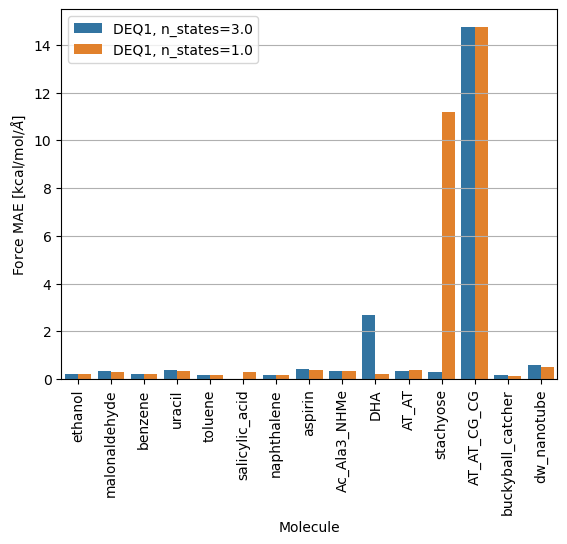

In [76]:
# compare n_states=3 to no fpc

df_nstates = []

for target in df["config.target"].unique():
    criteriatarget = {"config.target": target}

    # best DEQ
    criteria_deq = {
        "config.model_is_deq": True, "config.model.num_layers": 1, 
        "config.deq_kwargs.n_states": 3, "config.deq_kwargs.f_tol": 1e-2,
        # "config.model.enc_ln": False # model.enc_ln=True
        "config.model.attn_alpha_channels": 16,
    }
    anti_criteria = {"config.dname": "ccsd"}
    criteria_deq.update(criteriatarget)
    df_nstates = add_best_run(
        df_in=df, df_out=df_nstates, metric=error_metric, 
        criteria=criteria_deq, anti_criteria=anti_criteria
    )

    criteria_deq["config.deq_kwargs.n_states"] = 1.0
    criteria_deq.update(criteriatarget)
    df_nstates = add_best_run(
        df_in=df, df_out=df_nstates, metric=error_metric, 
        criteria=criteria_deq, anti_criteria=anti_criteria
        )

df_nstates = pd.concat(df_nstates)

# add n_states to "model" column
df_nstates["Model"] = df_nstates["Model"] + df_nstates["config.deq_kwargs.n_states"].apply(
    lambda x: f", n_states={x}" if x is not None else ""
)

# grouped barchart, with target as group, and model as hue
y = "summary.test_f_mae"
x = "config.target"
hue = "Model"
data = df_nstates.copy()

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/.png")
plt.show()

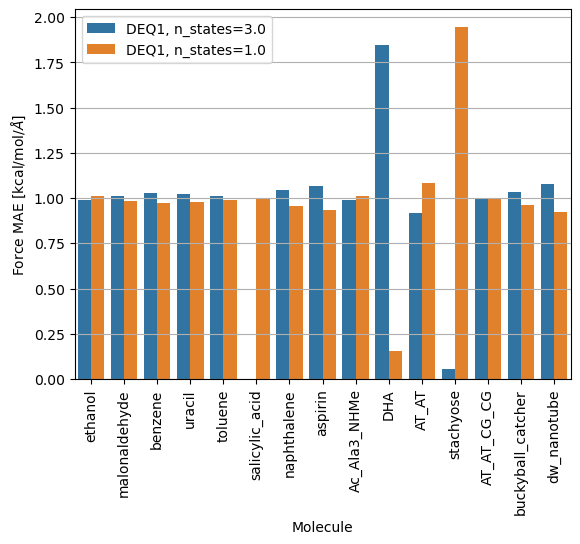

In [77]:
# compare n_states=3 to no fpc

# norm data[y] for each target
# data[y] = data.groupby(x)[y].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
data[y] = data.groupby(x)[y].transform(lambda x: x / x.mean())

# plot
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/.png")
plt.show()

# OC20

In [78]:
# Config
project = projectoc

if project == projectmd:
    error_metric = "summary.test_f_mae"
    energy_metric = "summary.test_e_mae"
elif project == projectoc:
    # summary.train/forces_mae, val, 
    error_metric = "summary.val/forces_mae"
    energy_metric = "summary.val/energy_mae"

Found 9 runs:
Saved dataframe.
Found 9 of 8+2 runs
before filter: 9
after filter: 9
replacing 9/9 0's with 200k
Adding maxdata to target
Adding optim.max_epochs to target


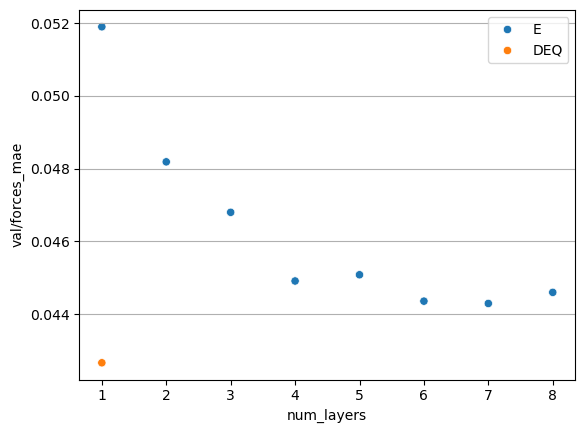

In [79]:
# plot acc over depth

if project == projectoc: 
    tag = "depthoc" 
    fname = "depthocv1"
else: 
    tag = "depthmd"
    fname = "depthmdv1"

dfdepth = get_runs_from_wandb(
    project=project, download_data=True, 
    filters = {
        "tags": tag,
        # "$and": [{"tags": "md17"}, {"tags": "eval"}],
        # "state": "finished",
        # "$or": [{"tags": "md17"}, {"tags": "main2"}, {"tags": "inference"}],
        "state": "finished",
        # "$or": [{"state": "finished"}, {"state": "crashed"}],
    }, 
    fname="depth" + fname
)
print(f"Found {len(dfdepth)} of 8+2 runs")

dfdepth = preprocess_df(df=dfdepth, project=project, error_metric=error_metric)

y = error_metric
x = "config.model.num_layers"
hue = "Class"
data = dfdepth.copy()

# plot
fig, ax = plt.subplots()
sns.scatterplot(
    x=x, y=y, hue=hue, data=data, ax=ax, 
    # palette=cdict
)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
# plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/n_steps.png")
plt.show()

In [80]:
[c for c in dfdepth.keys() if ("summary" in c) and ("gradients" not in c)]

['summary.ModelParameters',
 'summary._runtime',
 'summary._step',
 'summary._timestamp',
 'summary._wandb',
 'summary.train/energy_force_within_threshold',
 'summary.train/energy_mae',
 'summary.train/energy_pred_max',
 'summary.train/energy_pred_mean',
 'summary.train/energy_pred_min',
 'summary.train/energy_pred_std',
 'summary.train/energy_target_max',
 'summary.train/energy_target_mean',
 'summary.train/energy_target_min',
 'summary.train/energy_target_std',
 'summary.train/epoch',
 'summary.train/force_pred_max',
 'summary.train/force_pred_mean',
 'summary.train/force_pred_min',
 'summary.train/force_pred_std',
 'summary.train/force_target_max',
 'summary.train/force_target_mean',
 'summary.train/force_target_min',
 'summary.train/force_target_std',
 'summary.train/forces_cos',
 'summary.train/forces_mae',
 'summary.train/forces_magnitude',
 'summary.train/forcesx_mae',
 'summary.train/forcesy_mae',
 'summary.train/forcesz_mae',
 'summary.train/grad_norm',
 'summary.train/loss',


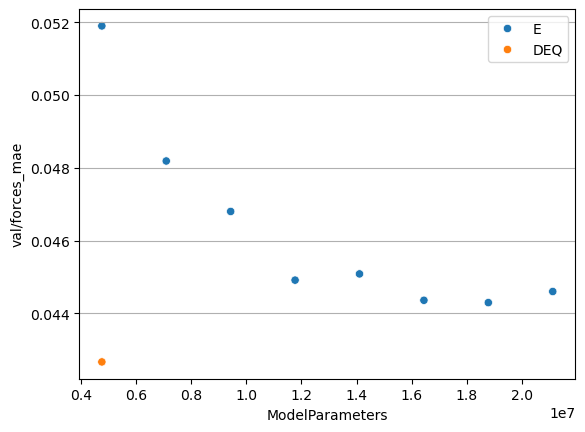

In [82]:
# Accuracy over model parameters
#  “summary.ModelParameters”

y = error_metric
# x = "config.model.num_layers"
x = "summary.ModelParameters"
hue = "Class"
data = dfdepth.copy()

# plot
fig, ax = plt.subplots()
sns.scatterplot(
    x=x, y=y, hue=hue, data=data, ax=ax, 
    # palette=cdict
)
plt.legend()
plt.xlabel(human_labels(x))
plt.ylabel(human_labels(y))

# vertical xtick labels
# plt.xticks(rotation=90)

# horizontal grid
plt.grid(axis="y")

# make a separate plot for each target

# save
# plt.savefig(f"{plotfolder}/n_steps.png")
plt.show()